In [1]:
!pip -q install scipy
!pip -q install numpy
!pip -q install tqdm
!pip -q install matplotlib
!pip -q install pandas
!pip -q install nltk

In [2]:
import sys
import numpy as np
import functools 
import pandas as pd
from scipy.stats import kendalltau
from collections import defaultdict
from utils import *
from numpy.random import choice
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.stats

np.set_printoptions(precision=3)

In [3]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [4]:
topics = get_topics(path_topic)

topics

{1: 'harvard university',
 2: 'black death',
 3: 'intergovernmental panel on climate change',
 4: 'private schools',
 5: 'geology',
 6: 'economic inequality',
 7: 'immune system',
 8: 'oxygen',
 9: 'normans',
 10: 'amazon rainforest',
 11: 'european union law'}

In [5]:
sub_topics = get_sub_topics(path_sub_topic)

sub_topics

defaultdict(list,
            {10: [1, 2, 3, 4, 5],
             5: [6, 7, 8, 9, 10, 11],
             6: [12, 13, 14, 15, 16, 17],
             4: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
             2: [28, 29, 30, 31, 32],
             9: [33, 34, 35, 36],
             1: [37, 38, 39, 40, 41],
             8: [42, 43, 44, 45, 46, 47, 48, 49, 50],
             11: [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
             7: [61, 62, 63, 64, 65, 66],
             3: [67, 68, 69, 70, 71, 72]})

In [6]:
session_ids = get_session_ids(path_log)

session_ids

[('A3J37RP5AZDACH', 5),
 ('A1UY2W2FL9CWN', 2),
 ('A1BWS5AD2T4NIR', 11),
 ('AA5ZDXAA2DLY1', 5),
 ('A2N9U74YIPDQ9F', 7),
 ('A1PVBXVZ1L7AN9', 10),
 ('AZZA3J049G7R5', 3),
 ('AA6RYE4V0IBKM', 3),
 ('A1LFKPNCX23XN6', 7),
 ('A3908297ZI3LES', 4),
 ('AK3H5QRAROFGP', 2),
 ('AHEEMGVMGEMEQ', 10),
 ('A1YGF0LJJGB30G', 2),
 ('A3TT7QV49VCZJ9', 11),
 ('A2T7VIFQS647LC', 7),
 ('A002160837SWJFPIAI7L7', 3),
 ('A3EZ3BRM1C5WKV', 9),
 ('AWJUGWPCUGKEG', 7),
 ('AH31QLJ57XC8W', 3),
 ('A21D9YDJU8K2QI', 6),
 ('A2CTA782EBXUCT', 4),
 ('A1BUBB41AO8TZ9', 2),
 ('A3HCGNV93TJO7R', 3),
 ('AYW62R027PUT1', 2),
 ('A3C0NQ2IP5FTZQ', 11),
 ('A2JW59JRBWUMR2', 6),
 ('A2JTSH1VPJQ8FR', 7),
 ('A2V66KLFVJTLKC', 2),
 ('A3RQR6LM6CHOMQ', 4),
 ('A2FBP73AQACKZ2', 7),
 ('A1GKD3NG1NNHRP', 10),
 ('A30RAYNDOWQ61S', 4),
 ('A1T0S48O0CMXBC', 2),
 ('A1BNGJBEWJS8WE', 9),
 ('A23TGEQ4CG90PA', 1),
 ('A1TR615HGENX1M', 4),
 ('AA6RYE4V0IBKM', 5),
 ('A3141EW4WZT4Q0', 4),
 ('A38LEVBZ3P5F6T', 4),
 ('A3DSXUOWWOT30T', 1),
 ('A12J4IRF5Z06BT', 7),
 ('A3JGSSDEJ0

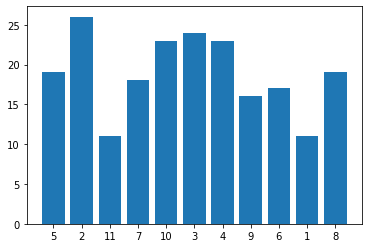

In [7]:
count_topics_per_user = defaultdict(int)

for user, topic in session_ids:
    count_topics_per_user[topic] += 1

plt.bar(range(len(count_topics_per_user)), list(count_topics_per_user.values()), align='center')
plt.xticks(range(len(count_topics_per_user)), list(count_topics_per_user.keys()))

plt.show()

In [8]:
all_sequences = get_all_sequences(path_log, session_ids)

#all_sequences

In [9]:
def get_transitions(sequence, max_sub_topic, include_rel = False):
    transitions = defaultdict(int)
    last_sub_topic = -1
    for action in sequence:
        current_sub_topic = action[0]
        sub_topic = action[3]
        rel = action[2]
        if not include_rel:
            transitions[(current_sub_topic, sub_topic)] += 1
        else:
            transitions[(current_sub_topic, sub_topic, rel)] += 1
        last_sub_topic = sub_topic
    if not include_rel:
        transitions[(last_sub_topic, max_sub_topic + 1)] += 1
    else:
        transitions[(last_sub_topic, max_sub_topic + 1, rel)] += 1
    return transitions

def aggregate_transitions(transitions_list):
    res = defaultdict(int)
    for transitions in transitions_list:
        for key in transitions:
            res[key] += transitions[key]
    return res

def normalize_sub_topics(transitions, min_sub_topic):
    res = defaultdict(int)
    for key in transitions:
        if key[0] == 0:
            res[(key[0], key[1] - min_sub_topic + 1)] = transitions[key]
        else:
            res[(key[0] - min_sub_topic + 1, key[1] - min_sub_topic + 1)] = transitions[key]
    return res

all_transitions = defaultdict(list)
for topic in all_sequences.keys():
    sequences = all_sequences[topic]
    transitions_list = []
    for sequence in sequences:
        transitions = get_transitions(sequence, max(sub_topics[topic]))
        transitions_list.append(transitions)
    all_transitions[topic] = normalize_sub_topics(aggregate_transitions(transitions_list), min(sub_topics[topic]))
    
#all_transitions

# Fitting the best Alpha

In [10]:
gp = defaultdict(int)
for topic in all_sequences:
    for sequence in all_sequences[topic]:
        for m, _ in enumerate(sequence):
            gp[m] += 1

ngp = np.array([value for key, value in gp.items()])
ngp = ngp / np.sum(ngp)

ngp

array([0.184, 0.167, 0.159, 0.143, 0.118, 0.081, 0.054, 0.035, 0.023,
       0.012, 0.008, 0.005, 0.005, 0.004, 0.002])

In [11]:
# CP

def dd_cp():
    return 1

def d_cp(): # precision
    return dd_cp()

# CBP

def dd_cbp(alpha, m):
    return alpha ** m

def d_cbp(alpha, m): # cbp
    return dd_cbp(alpha, m)

# CBP +

def dd_cbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    for _ in range(m - len(sequence)):
        res *= beta
    return res

def d_cbp_p(alpha, beta, m, all_sequences):
    res = 0.0
    n = 0.0
    for topic_id, topic in enumerate(topics):
        for sequence in all_sequences[topic]:
            #if m < len(sequence):
            res += dd_cbp_p(alpha, beta, m, sequence)
            n += 1.0
    return res/n

for i in range(15):
    print(d_cbp_p(1.0, 0.8, i, all_sequences), d_cbp(0.8, i), d_cp(), ngp[i])

1.0 1.0 1 0.18432769367764915
0.9690821256038651 0.8 1 0.16651825467497774
0.9140096618357493 0.6400000000000001 1 0.15939447907390916
0.8547246376811592 0.5120000000000001 1 0.1433659839715049
0.7843014492753625 0.4096000000000001 1 0.11754229741763135
0.7070005797101447 0.3276800000000001 1 0.08103294746215495
0.6100229565217389 0.2621440000000001 1 0.05431878895814782
0.5157501526570046 0.20971520000000007 1 0.034728406055209264
0.4251413395169083 0.1677721600000001 1 0.02315227070347284
0.3477897324830916 0.13421772800000006 1 0.01157613535173642
0.2800495096579709 0.10737418240000006 1 0.008014247551202136
0.2262728676297582 0.08589934592000005 1 0.005342831700801425
0.1815129800941448 0.06871947673600004 1 0.005342831700801425
0.14570507006565403 0.054975581388800036 1 0.003561887800534283
0.11705874204286149 0.043980465111040035 1 0.0017809439002671415


## Precision@Length Model

In [12]:
min_err = sys.float_info.max
res = 100
M = len(ngp)
gt = ngp

def tse_cp():
    norm = 0.0
    for i in range(M):
        norm += d_cp()
    err = 0.0
    y_cp = []
    for i in range(M):
        val = d_cp()/norm
        y_cp.append(val)
        err += (gt[i]-val)**2
    return err, y_cp

min_err, y_cp = tse_cp()

print("l(TSE) = {:.4f}".format(np.log(min_err)))

def tae_cp():
    norm = 0.0
    for i in range(M):
        norm += d_cp()
    err = 0.0
    for i in range(M):
        val = d_cp()/norm
        err += abs(gt[i]-val)        
    return err

print("l(TAE) = {:.4f}".format(np.log(tae_cp())))

def kl_cp():
    norm = 0.0
    for i in range(M):
        norm += d_cp()
    err = 0.0
    for i in range(M):
        val = d_cp()/norm
        err += -gt[i] * np.log(val/gt[i])        
    return err

print("KL = {:.4f}".format(kl_cp()))

l(TSE) = -2.7129
l(TAE) = -0.1005
KL = 0.5317


## Conversational Biased Precision Model

In [13]:
min_err = sys.float_info.max
res = 100
best_alpha = -1
M = len(ngp)
gt = ngp

y_cbp = []
def tse_cbp(a):
    y_cbp = []
    norm = 0.0
    for i in range(M):
        norm += d_cbp(a, i)
    err = 0.0
    for i in range(M):
        val = d_cbp(a, i)/norm
        y_cbp.append(val)
        err += (gt[i]-val)**2
    return err, y_cbp

for a_i, a in enumerate(tqdm(np.linspace(0, 1, res+1))):        
    err, _y_cbp = tse_cbp(a)
        
    if err < min_err:
        min_err = err
        best_alpha = a
        y_cbp = _y_cbp

best_alpha_cbp = best_alpha

print("a =", best_alpha) 
print("l(TSE) = {:.4f}".format(np.log(min_err)))

def tae_cbp(a):
    norm = 0.0
    for i in range(M):
        norm += d_cbp(a, i)
    err = 0.0
    for i in range(M):
        val = d_cbp(a, i)/norm
        err += abs(gt[i]-val)        
    return err

print("l(TAE) = {:.4f}".format(np.log(tae_cbp(best_alpha))))

def kl_cbp(a):
    norm = 0.0
    for i in range(M):
        norm += d_cbp(a, i)
    err = 0.0
    for i in range(M):
        val = d_cbp(a, i)/norm
        err += -gt[i] * np.log(val/gt[i])        
    return err

print("KL = {:.4f}".format(kl_cbp(best_alpha)))


a = 0.8
l(TSE) = -5.3199
l(TAE) = -1.5106
KL = 0.0496


## Conversational Biased Precision + Model

In [14]:
min_err = sys.float_info.max
res = 100
best_alpha = -1
best_beta = -1
M = len(ngp)
gt = ngp

y_cbp_p = []
def tse_cbp_p(a, b):
    y_cbp_p = []
    err = 0.0
    norm = 0.0
    for i in range(M):
        norm += d_cbp_p(a, b, i, all_sequences)
    for i in range(M):
        val = d_cbp_p(a, b, i, all_sequences)/norm
        y_cbp_p.append(val)
        err += (gt[i]-val)**2
    return err, y_cbp_p

for a_i, a in enumerate(tqdm(np.linspace(0, 1, 1*res+1))):      
    
    for b_i, b in enumerate(np.linspace(0, 1, res+1)):        
    
        err, _y_cbp_p = tse_cbp_p(a, b)

        if err < min_err:
            min_err = err
            best_alpha = a
            best_beta = b
            y_cbp_p = _y_cbp_p


best_alpha_cbp_p = best_alpha
best_beta_cbp_p = best_beta

print("a =", best_alpha, "b =", best_beta)
print("l(TSE) = {:.4f}".format(np.log(min_err)))

def tae_cbp_p(a, b):
    norm = 0.0
    for i in range(M):
        norm += d_cbp_p(a, b, i, all_sequences)
    err = 0.0
    for i in range(M):
        val = d_cbp_p(a, b, i, all_sequences)/norm
        err += abs(gt[i]-val)        
    return err

print("l(TAE) = {:.4f}".format(np.log(tae_cbp_p(best_alpha, best_beta))))

def kl_cbp_p(a, b):
    norm = 0.0
    for i in range(M):
        norm += d_cbp_p(a, b, i, all_sequences)
    err = 0.0
    for i in range(M):
        val = d_cbp_p(a, b, i, all_sequences)/norm
        err += -gt[i] * np.log(val/gt[i])        
    return err

print("KL = {:.4f}".format(kl_cbp_p(best_alpha, best_beta)))


a = 1.0 b = 0.53
l(TSE) = -7.5696
l(TAE) = -2.6574
KL = 0.0054


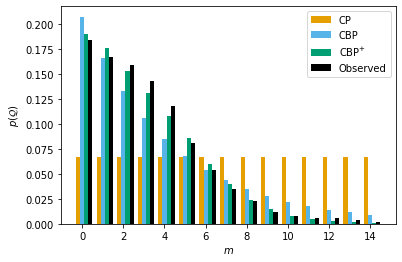

In [15]:
x = np.arange(M)

bar_width = 0.20

plt.bar(x-bar_width*1, y_cp, width = bar_width, color='#E69F00', align='center', label='CP')
plt.bar(x+bar_width*0, y_cbp, width = bar_width, color='#56B4E9', align='center', label='CBP')
plt.bar(x+bar_width*1, y_cbp_p, width = bar_width, color='#009E73', align='center', label="CBP$^{+}$")
plt.bar(x+bar_width*2, gt, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$p(\\mathcal{Q})$')
plt.xlabel('$m$')

plt.legend()
plt.savefig("probability_of_querying.png", dpi=300)

# Condition Probability Analysis

## Same vs Other Topic

In [17]:
probs = defaultdict(int)
transitions_tables = {}
for topic_id, topic in enumerate(topics):
    sequences = all_sequences[topic]
    
    for sequence in sequences:
        #print(sequence)
        prev_item = sequence[0]
        for item in sequence[1:]:
            if prev_item[2] == 'relevant':
                if item[3] == prev_item[3]:
                    #print("rel, same topic")
                    probs["same | rel"] += 1
                else:
                    #print("rel, different")
                    probs["different | rel"] += 1
            else:
                if item[3] == prev_item[3]:
                    #print("not_rel, same")
                    probs["same | not_rel"] += 1
                else:
                    #print("not_rel, different")
                    probs["different | not_rel"] += 1
            prev_item = item
    
norm_rel = sum([value for key, value in probs.items() if "not_rel" not in  key])
norm_not_rel = sum([value for key, value in probs.items() if "not_rel" in  key])

for key, value in probs.items():
    if "not_rel" not in key:
        print(key, value / norm_rel)
        probs[key] = value/norm_rel
    else: 
        print(key, value / norm_not_rel)
        probs[key] = value/norm_not_rel

different | rel 0.8789237668161435
same | not_rel 0.340080971659919
different | not_rel 0.659919028340081
same | rel 0.1210762331838565


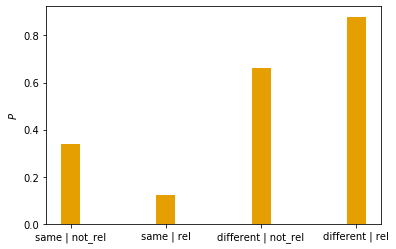

In [18]:
x = ['same | not_rel', 'same | rel', 'different | not_rel', 'different | rel']

bar_width = 0.20

y = [probs['same | not_rel'], probs['same | rel'], probs['different | not_rel'], probs['different | rel']]

plt.bar(x, y, width = bar_width, color='#E69F00', align='center')

#plt.rc('font', size=13)
plt.ylabel('$P$')

#plt.savefig("probability_of_querying.png", dpi=300)
plt.show()

## Influence of a Relevant Document to the next Subtopic

In [19]:
# from users
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if rel == 'relevant':
                if topic not in qrels_users:
                    qrels_users[topic] = {}
                if sub_topic not in qrels_users[topic]:
                    qrels_users[topic][sub_topic] = set()
                qrels_users[topic][sub_topic].add(paragraph)

#qrels_users

In [20]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

#qrels

In [21]:
#P(of quering a sub_topic to which the examined document belongs | current doc is relevant to the current query and the queried sub_topic)

def get_rel_sub_topics(document, topic):
    rel_sub_topics = set()
    for sub_topic in qrels_users[topic]:
        if document in qrels_users[topic][sub_topic]:
            rel_sub_topics.add(sub_topic)
    return rel_sub_topics

probs = defaultdict(int)

num = 0
den = 0
for topic in topics:
    sequences = all_sequences[topic]
    for sequence in sequences:
        prev_action = sequence[0]
        for action in sequence[1:]:
            rel_sub_topics = get_rel_sub_topics(prev_action[1], topic)
            if prev_action[2] == 'relevant' and prev_action[1] != action[1] and len(rel_sub_topics) > 1:
                #print(prev_action, action, get_rel_sub_topics(prev_action[1], topic))
                if action[3] in rel_sub_topics:
                    num += 1
                den += 1
            prev_action = action
            
print(num, den, num/den)

33 286 0.11538461538461539


## How many times our qrels agree with the user relevance?

In [22]:
probs = defaultdict(int)
transitions_tables = {}

for topic in topics:
    sequences = all_sequences[topic]
    for sequence in sequences:
        for action in sequence[1:]:
            #print(action)
            if action[2] == 'relevant':
                probs["TP"] += 1
            else:
                probs["FP"] += 1
            
norm = sum(probs.values())
for key, value in probs.items():
    print(key, value / norm)
print(norm)

print(probs["TP"]/norm)

FP 0.3002183406113537
TP 0.6997816593886463
916
0.6997816593886463


# Correlation Analysis (CBS score vs Satisfaction)

In [62]:
# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) * (1 - alpha) #/ norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_ncbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i)
    return res * (1 - alpha) #/norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

In [63]:
ncbp_p_scores = []
ncbp_scores = []
ncp_scores = []

print(best_alpha_cbp_p, best_beta_cbp_p)
print(best_alpha_cbp)

for topic in topics:
    sequences = all_sequences[topic]
    if(len(sequences) > 0):
        ncbp_p_scores.append((topic, get_ncbp_p_list(sequences, best_alpha_cbp_p, best_beta_cbp_p)))
        ncbp_scores.append((topic, get_ncbp_list(sequences, best_alpha_cbp)))
        ncp_scores.append((topic, get_ncp_list(sequences)))
    
#ncbp_p_scores, ncbp_scores, ncp_scores

1.0 0.53
0.8


In [56]:
# new version
def get_satisfaction(lines):
    reg_exp = RegExp()
    satisfaction = None
    for line in lines:
        items = line.split('\t')
        content = items[2]
        if reg_exp.get(r'user is (.+)', content):
            satisfaction = reg_exp.res
    return satisfaction

# new
def get_all_satisfactions(path_log, session_ids):
    res = defaultdict(list)
    for session_id in session_ids:
        selected_lines = []
        with open(path_log) as f:
            for line in f.readlines()[1:]:
                items = line.split('\t')
                user = items[3].strip()
                topic = int(items[4].strip())
                if user == session_id[0] and topic == session_id[1]:
                    selected_lines.append(line)

        satisfaction = get_satisfaction(selected_lines)
        res[session_id[1]].append(satisfaction)
    return res

all_satisfactions = get_all_satisfactions(path_log, session_ids)

satisfaction_scores = []
for topic in topics:
    satisfactions = all_satisfactions[topic]
    if len(satisfactions) > 0:
        satisfaction_score = []
        for satisfaction in satisfactions:
            if satisfaction == 'satisfied':
                #satisfaction_score += 1
        #satisfaction_score /= len(satisfactions)
                satisfaction_score.append(1.0)
            else:
                satisfaction_score.append(0.0)
        satisfaction_scores.append((topic, satisfaction_score))
        
satisfaction_scores = sorted(satisfaction_scores)
#satisfaction_scores

In [58]:
def unpack(l):
    return [np.mean(i[1]) for i in l]
    #return functools.reduce(list.__add__, [i[1] for i in l])

print("CBP+", scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(satisfaction_scores)))
print("CBP", scipy.stats.kendalltau(unpack(ncbp_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_scores), unpack(satisfaction_scores)))
print()
print("CBP+", scipy.stats.spearmanr(unpack(ncbp_p_scores), unpack(satisfaction_scores)))
print("CBP", scipy.stats.spearmanr(unpack(ncbp_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_scores), unpack(satisfaction_scores)))
print()
print("CBP+", scipy.stats.pearsonr(unpack(ncbp_p_scores), unpack(satisfaction_scores)))
print("CBP", scipy.stats.pearsonr(unpack(ncbp_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_scores), unpack(satisfaction_scores)))

CBP+ KendalltauResult(correlation=0.7339758434175737, pvalue=0.001787289036987269)
CBP KendalltauResult(correlation=0.7339758434175737, pvalue=0.001787289036987269)
P KendalltauResult(correlation=0.697277051246695, pvalue=0.0030042622393982835)

CBP+ SpearmanrResult(correlation=0.870161710874372, pvalue=0.0004954180897534654)
CBP SpearmanrResult(correlation=0.8610500699228079, pvalue=0.0006630680655063411)
P SpearmanrResult(correlation=0.8382709675438977, pvalue=0.0012683508950782564)

CBP+ (0.9087589613730382, 0.00010728674977454765)
CBP (0.8952368820424176, 0.00019583986261185402)
P (0.9178106884834428, 6.794784339952218e-05)


In [59]:
print("CBP+", scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncbp_p_scores)))
print("CBP", scipy.stats.kendalltau(unpack(ncbp_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_scores), unpack(ncbp_p_scores)))
print()
print("CBP+", scipy.stats.spearmanr(unpack(ncbp_p_scores), unpack(ncbp_p_scores)))
print("CBP", scipy.stats.spearmanr(unpack(ncbp_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_scores), unpack(ncbp_p_scores)))
print()
print("CBP+", scipy.stats.pearsonr(unpack(ncbp_p_scores), unpack(ncbp_p_scores)))
print("CBP", scipy.stats.pearsonr(unpack(ncbp_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_scores), unpack(ncbp_p_scores)))

CBP+ KendalltauResult(correlation=1.0, pvalue=5.010421677088344e-08)
CBP KendalltauResult(correlation=0.9272727272727274, pvalue=3.2567740901074234e-06)
P KendalltauResult(correlation=0.9636363636363636, pvalue=5.511463844797178e-07)

CBP+ SpearmanrResult(correlation=1.0, pvalue=0.0)
CBP SpearmanrResult(correlation=0.9818181818181818, pvalue=8.403066433955246e-08)
P SpearmanrResult(correlation=0.990909090909091, pvalue=3.762571807085399e-09)

CBP+ (1.0, 0.0)
CBP (0.9908720779855791, 3.831796444946052e-09)
P (0.9764975391449429, 2.646947975423023e-07)


In [60]:
print("CBP+", scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncbp_scores)))
print("CBP", scipy.stats.kendalltau(unpack(ncbp_scores), unpack(ncbp_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_scores), unpack(ncbp_scores)))
print()
print("CBP+", scipy.stats.spearmanr(unpack(ncbp_p_scores), unpack(ncbp_scores)))
print("CBP", scipy.stats.spearmanr(unpack(ncbp_scores), unpack(ncbp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_scores), unpack(ncbp_scores)))
print()
print("CBP+", scipy.stats.pearsonr(unpack(ncbp_p_scores), unpack(ncbp_scores)))
print("CBP", scipy.stats.pearsonr(unpack(ncbp_scores), unpack(ncbp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_scores), unpack(ncbp_scores)))

CBP+ KendalltauResult(correlation=0.9272727272727274, pvalue=3.2567740901074234e-06)
CBP KendalltauResult(correlation=1.0, pvalue=5.010421677088344e-08)
P KendalltauResult(correlation=0.9636363636363636, pvalue=5.511463844797178e-07)

CBP+ SpearmanrResult(correlation=0.9818181818181818, pvalue=8.403066433955246e-08)
CBP SpearmanrResult(correlation=1.0, pvalue=0.0)
P SpearmanrResult(correlation=0.990909090909091, pvalue=3.762571807085399e-09)

CBP+ (0.9908720779855791, 3.831796444946052e-09)
CBP (1.0, 0.0)
P (0.9850665614677211, 3.4819425975229315e-08)


In [61]:
print("CBP+", scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncp_scores)))
print("CBP", scipy.stats.kendalltau(unpack(ncbp_scores), unpack(ncp_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_scores), unpack(ncp_scores)))
print()
print("CBP+", scipy.stats.spearmanr(unpack(ncbp_p_scores), unpack(ncp_scores)))
print("CBP", scipy.stats.spearmanr(unpack(ncbp_scores), unpack(ncp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_scores), unpack(ncp_scores)))
print()
print("CBP+", scipy.stats.pearsonr(unpack(ncbp_p_scores), unpack(ncp_scores)))
print("CBP", scipy.stats.pearsonr(unpack(ncbp_scores), unpack(ncp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_scores), unpack(ncp_scores)))

CBP+ KendalltauResult(correlation=0.9636363636363636, pvalue=5.511463844797178e-07)
CBP KendalltauResult(correlation=0.9636363636363636, pvalue=5.511463844797178e-07)
P KendalltauResult(correlation=1.0, pvalue=5.010421677088344e-08)

CBP+ SpearmanrResult(correlation=0.990909090909091, pvalue=3.762571807085399e-09)
CBP SpearmanrResult(correlation=0.990909090909091, pvalue=3.762571807085399e-09)
P SpearmanrResult(correlation=1.0, pvalue=0.0)

CBP+ (0.9764975391449429, 2.646947975423023e-07)
CBP (0.9850665614677211, 3.4819425975229315e-08)
P (0.9999999999999999, 9.370452282996262e-72)


KendalltauResult(correlation=0.8181818181818182, pvalue=0.00013227513227513228)


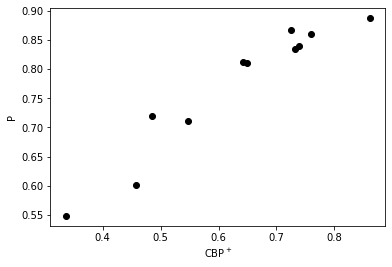

In [83]:
plt.plot(unpack(ncbp_p_scores), unpack(ncp_scores), 'o', color='black')

plt.xlabel('CBP$^+$')
plt.ylabel('P')

plt.savefig("CBP_P_vs_P.png", dpi=300)
print(scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncp_scores)))

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)


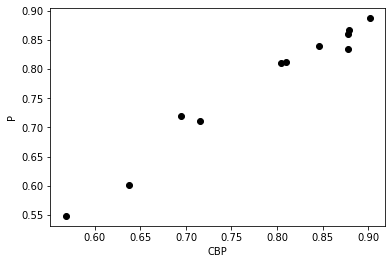

In [85]:
plt.plot(unpack(ncbp_scores), unpack(ncp_scores), 'o', color='black')

plt.xlabel('CBP')
plt.ylabel('P')

plt.savefig("CBP_vs_P.png", dpi=300)
print(scipy.stats.kendalltau(unpack(ncbp_scores), unpack(ncp_scores)))

KendalltauResult(correlation=0.7818181818181819, pvalue=0.0003334435626102293)


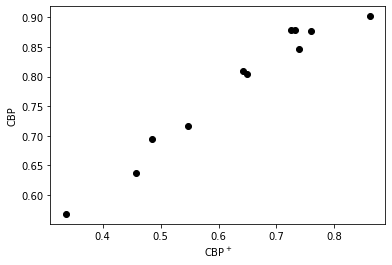

In [86]:
plt.plot(unpack(ncbp_p_scores), unpack(ncbp_scores), 'o', color='black')

plt.xlabel('CBP$^+$')
plt.ylabel('CBP')

plt.savefig("CBP_P_vs_CBP.png", dpi=300)
print(scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncbp_scores)))